In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

print(holdout.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for c in ['Age_categories',
              'Fare_categories',
              'Title',
              'Cabin_type',
              'Sex']:
        df = create_dummies(df, c)
    
    return df

train = process_df(train)
holdout = process_df(holdout)

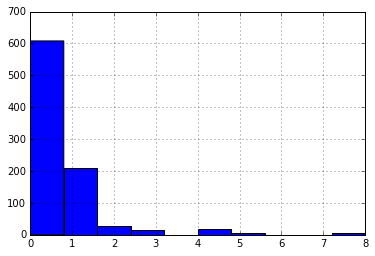

In [5]:
train['SibSp'].hist()

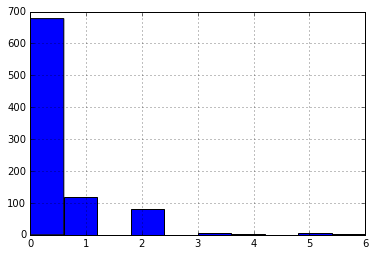

In [6]:
train['Parch'].hist()

In [7]:
explore = train[['SibSp', 'Parch', 'Survived']].copy()
explore['familysize'] = explore['SibSp'] + explore['Parch']

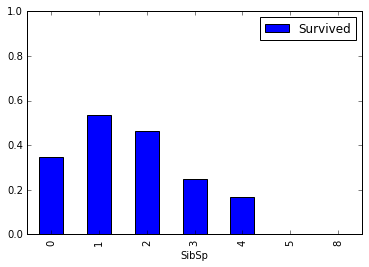

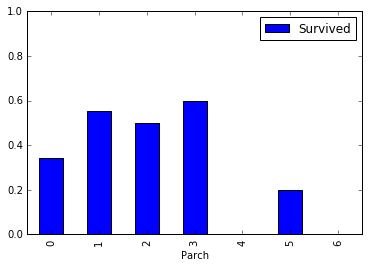

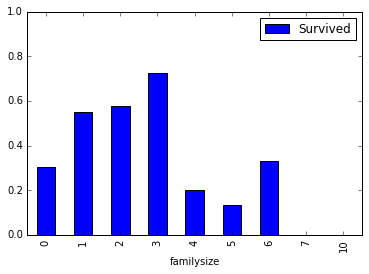

In [8]:
for c in ['SibSp', 'Parch', 'familysize']:
    pivot = explore.pivot_table(index=c,values="Survived")
    pivot.plot.bar(ylim=(0,1))
    plt.show()

Passengers with a medium size of family size (1-3) tend to have a better chance of survival.

In [9]:
def process_isalone(df):
    col = df['SibSp'].copy()
    col[:] = 0
    col[df['SibSp'] + df['Parch'] == 0] = 1
    df['isalone'] = col
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

In [10]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print(best_columns)
    return best_columns

cols = select_features(train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [11]:
def select_model(df, cols):
    all_X = df[cols]
    all_y = df['Survived']
    
    lr_dict = {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
        {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }
    }
    
    knn_dict = {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
    }
    
    clf_dict = {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    }
    
    list_models = [lr_dict, knn_dict, clf_dict]
    
    for m in list_models:
        print(m['name'])
        grid = GridSearchCV(m['estimator'], m['hyperparameters'],cv=10)
        grid.fit(all_X, all_y)
        m["best_params"] = grid.best_params_
        m["best_score"] = grid.best_score_
        m["best_model"] = grid.best_estimator_
        print("Best Score: {}".format(m["best_score"]))
        print("Best Parameters: \n{}\n".format(m["best_params"]))
    
    return list_models

best_models = select_model(train, cols)

LogisticRegression
Best Score: 0.8204264870931538
Best Parameters: 
{'solver': 'liblinear'}

KNeighborsClassifier
Best Score: 0.7755331088664422
Best Parameters: 
{'weights': 'uniform', 'algorithm': 'brute', 'n_neighbors': 5, 'p': 1}

RandomForestClassifier
Best Score: 0.8395061728395061
Best Parameters: 
{'criterion': 'gini', 'min_samples_split': 3, 'n_estimators': 9, 'min_samples_leaf': 1, 'max_depth': 10, 'max_features': 'log2'}



In [12]:
def save_submission_file(model, cols, filename='submission.csv'):
    predictions = model.predict(holdout[cols])
    sub_df = {'PassengerId':holdout['PassengerId'],
             'Survived':predictions}
    submission = pd.DataFrame(sub_df)
    submission.to_csv(filename,index=False)

best_rf_model = best_models[2]["best_model"]
save_submission_file(best_rf_model,cols)